## Problem Statement

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

## Dataset Description

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

**walmart_data.csv**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## 1. Importing the libraries and data

In [181]:
# Libraries for data analysis
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Libraries for feature selection
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Libraries used during modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

# Libraries for machine learning models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor

# Artificial Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Libraries for model evaluation
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore') 

In [20]:
#!pip install ELI5



     -------------------------------------- 216.2/216.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ELI5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107768 sha256=d96e633fbc9ff7d79507b2c01cd5cd8eb2dbdda454ab88d6a0db3894262d34d9
  Stored in directory: c:\users\dinesh kumar\appdata\local\pip\cache\wheels\79\6c\4b\13ea3238d017bc19711b4312359e2c95be91a1a9d60d949572
Successfully built ELI5


In [26]:
curr_dir = os.getcwd()

In [31]:
features = pd.read_csv(curr_dir + '\\Features_data_set.csv')
stores = pd.read_csv(curr_dir + '\\stores_data_set.csv')
walmart_data = pd.read_csv(curr_dir + '\\sales_data_set.csv')

# test = pd.read_csv('C:\\Users\\DELL\\Documents\\Data Science\\Projects\\Walmart Sales Prediction\\Data\\test.csv')
# sample_submission = pd.read_csv('C:\\Users\\DELL\\Documents\\Data Science\\Projects\\Walmart Sales Prediction\\Data\\sampleSubmission.csv')

In [34]:
walmart_data

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
...,...,...,...,...,...
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False


## 2. Data Exploration

In [35]:
feature_store = features.merge(stores, how='inner', on = "Store")

# Converting date column to datetime 
feature_store['Date'] = pd.to_datetime(feature_store['Date'])
walmart_data['Date'] = pd.to_datetime(walmart_data['Date'])
# test['Date'] = pd.to_datetime(test['Date'])

# Adding some basic datetime features
# feature_store['Day'] = feature_store['Date'].dt.day  # Since the data is available on a weekly basis, day isn't that important
feature_store['Week'] = feature_store['Date'].dt.week
feature_store['Month'] = feature_store['Date'].dt.month
feature_store['Year'] = feature_store['Date'].dt.year

In [36]:
original_df = walmart_data.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [37]:
#Checking the dtypes of all the columns

original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [68]:
#Checking number of unique rows in each feature

original_df.nunique().sort_values()

IsHoliday            2
Year                 3
Type                 3
Month               12
Size                40
Store               45
Week                52
Dept                81
Date               143
Unemployment       349
Fuel_Price         892
MarkDown2         1499
MarkDown3         1662
MarkDown4         1944
CPI               2145
MarkDown1         2277
MarkDown5         2293
Temperature       3528
Weekly_Sales    359464
dtype: int64

In [40]:
original_df.columns


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Week', 'Month',
       'Year'],
      dtype='object')

In [41]:
original_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2010-01-10,20094.19,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,A,151315,1,1,2010
1,1,1,2010-02-04,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,A,151315,5,2,2010
2,1,1,2010-02-07,16333.14,False,80.91,2.669,NaN,NaN,NaN,NaN,NaN,211.223533,7.787,A,151315,5,2,2010
3,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2,2010
4,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-10-08,727.49,False,78.65,3.722,17868.84,50.60,57.66,2593.93,1890.59,191.162613,8.684,B,118221,41,10,2012
421566,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,10,2012
421567,45,98,2012-10-26,1076.80,False,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,43,10,2012
421568,45,98,2012-11-05,893.60,False,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,B,118221,45,11,2012


In [42]:
cf=['Store', 'Dept', 'IsHoliday','Type', 'Date', 'Week', 'Month', 'Year']  # Categorical Features
nf=[i for i in original_df.columns if i not in cf]  # Numerical features

In [43]:
#Checking the stats of all the columns
display(original_df.describe())

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Week,Month,Year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739,26.013457,6.478580,2010.968591
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328,14.525832,3.324757,0.796876
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000,14.000000,4.000000,2010.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000,26.000000,6.000000,2011.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000,38.000000,9.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,52.000000,12.000000,2012.000000


## 3. Exploratory Data Analysis

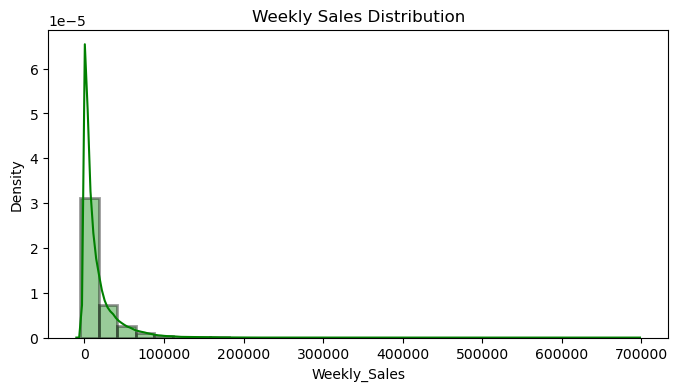

In [44]:
#Analyzing the distribution of target variable

plt.figure(figsize=[8,4])
sns.distplot(original_df['Weekly_Sales'], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Weekly Sales Distribution')
plt.show()

**Inference:**

- Weekly Sales data has a positively skewed distribution.

                             Visualising Categorical Features:                              


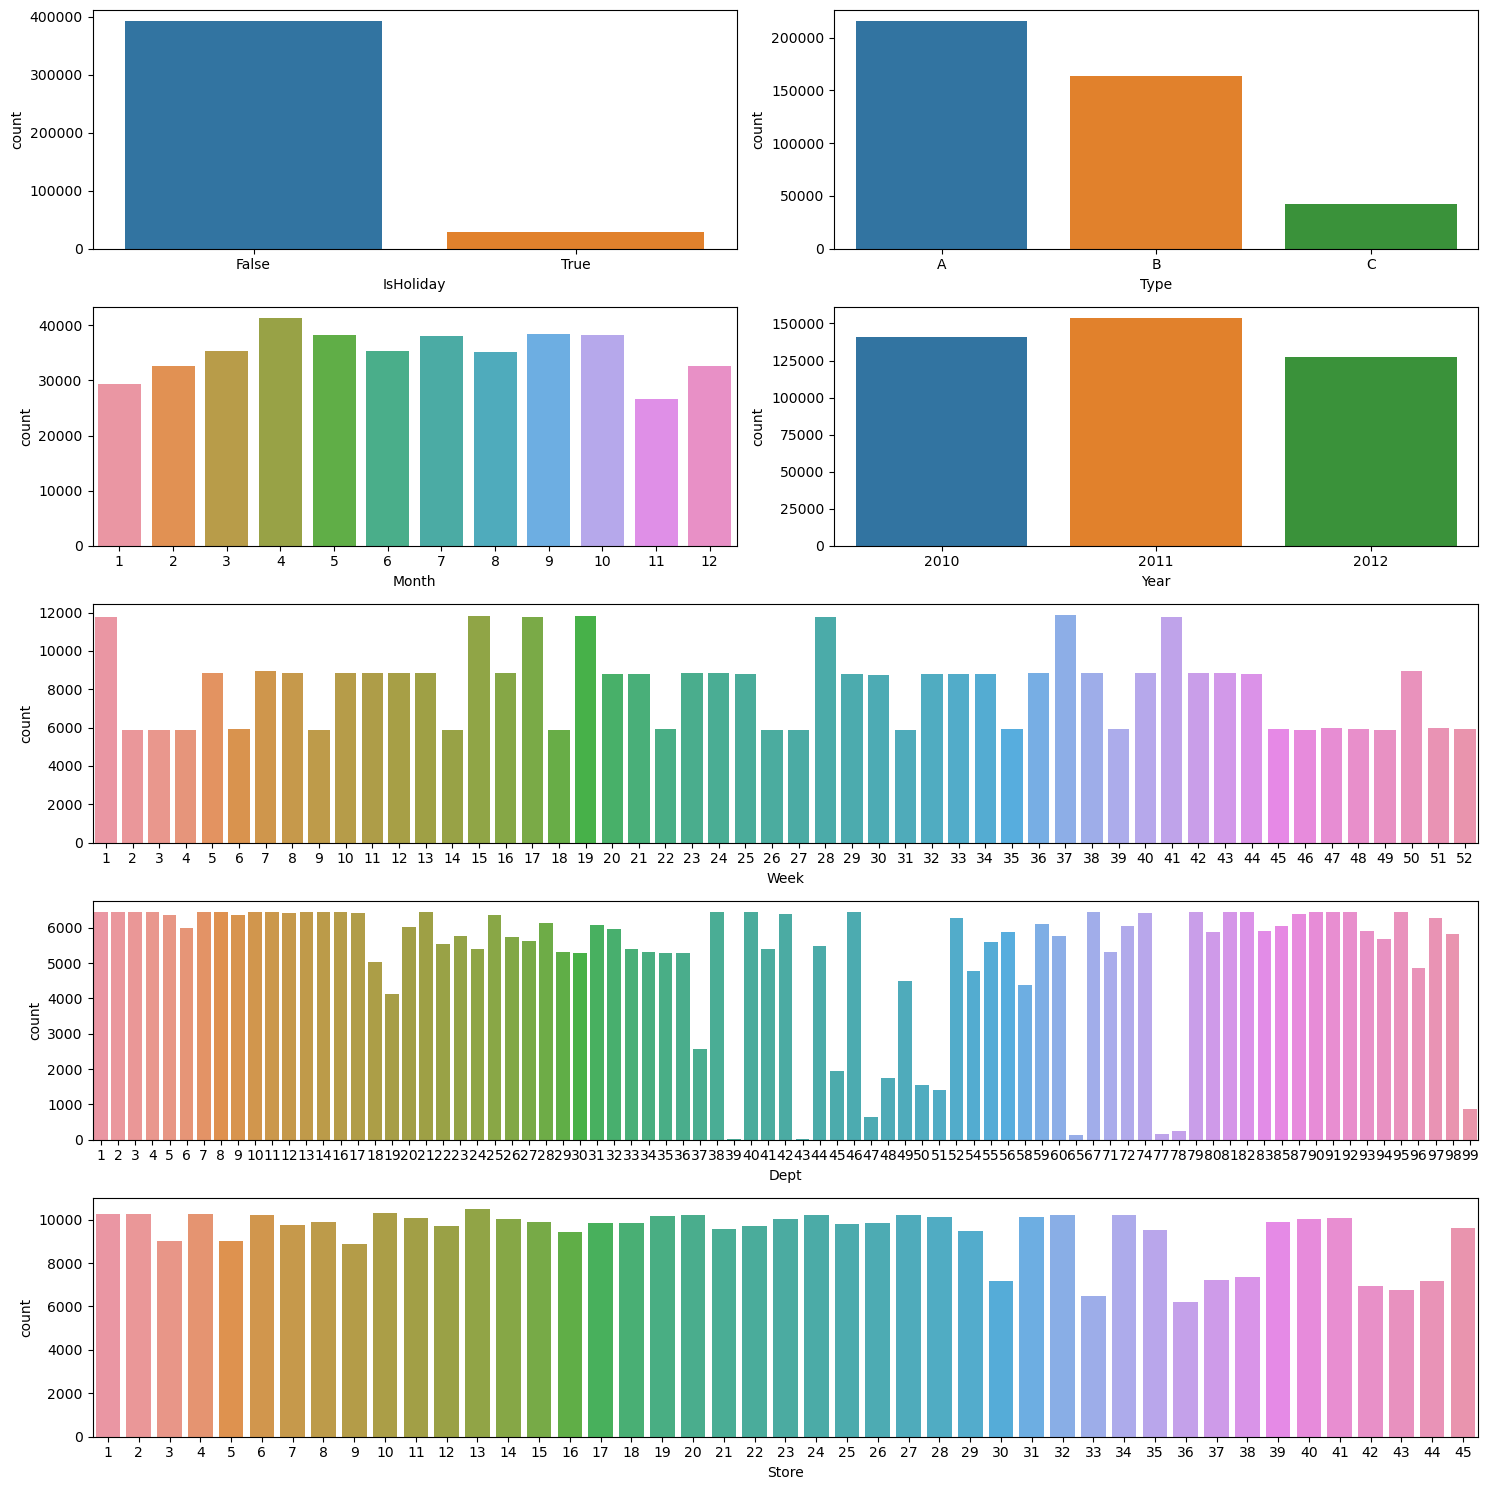

In [45]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:\033[0m'.center(100))

# Define the list of features to plot
plot_cf = ['Store', 'Dept', 'IsHoliday', 'Type', 'Week', 'Month', 'Year']

# print(num_rows, num_cols)
plt.figure(figsize=(15, 15))

plt.subplot(5, 2, 1)
sns.countplot(data=original_df, x='IsHoliday')

plt.subplot(5, 2, 2)
sns.countplot(data=original_df, x='Type')

plt.subplot(5, 2, 3)
sns.countplot(data=original_df, x='Month')

plt.subplot(5, 2, 4)
sns.countplot(data=original_df, x='Year')

plt.subplot(5, 1, 3)
sns.countplot(data=original_df, x='Week')

plt.subplot(5, 1, 4)
sns.countplot(data=original_df, x='Dept')

plt.subplot(5, 1, 5)
sns.countplot(data=original_df, x='Store')

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

**Inference:**

- Some of the departments are underrepresented in the dataset. 
- Also, Type C store is underrepresented in the dataset.
- There are only few holiday weeks in the dataset. 

                                                Numeric Features Distribution                                                 


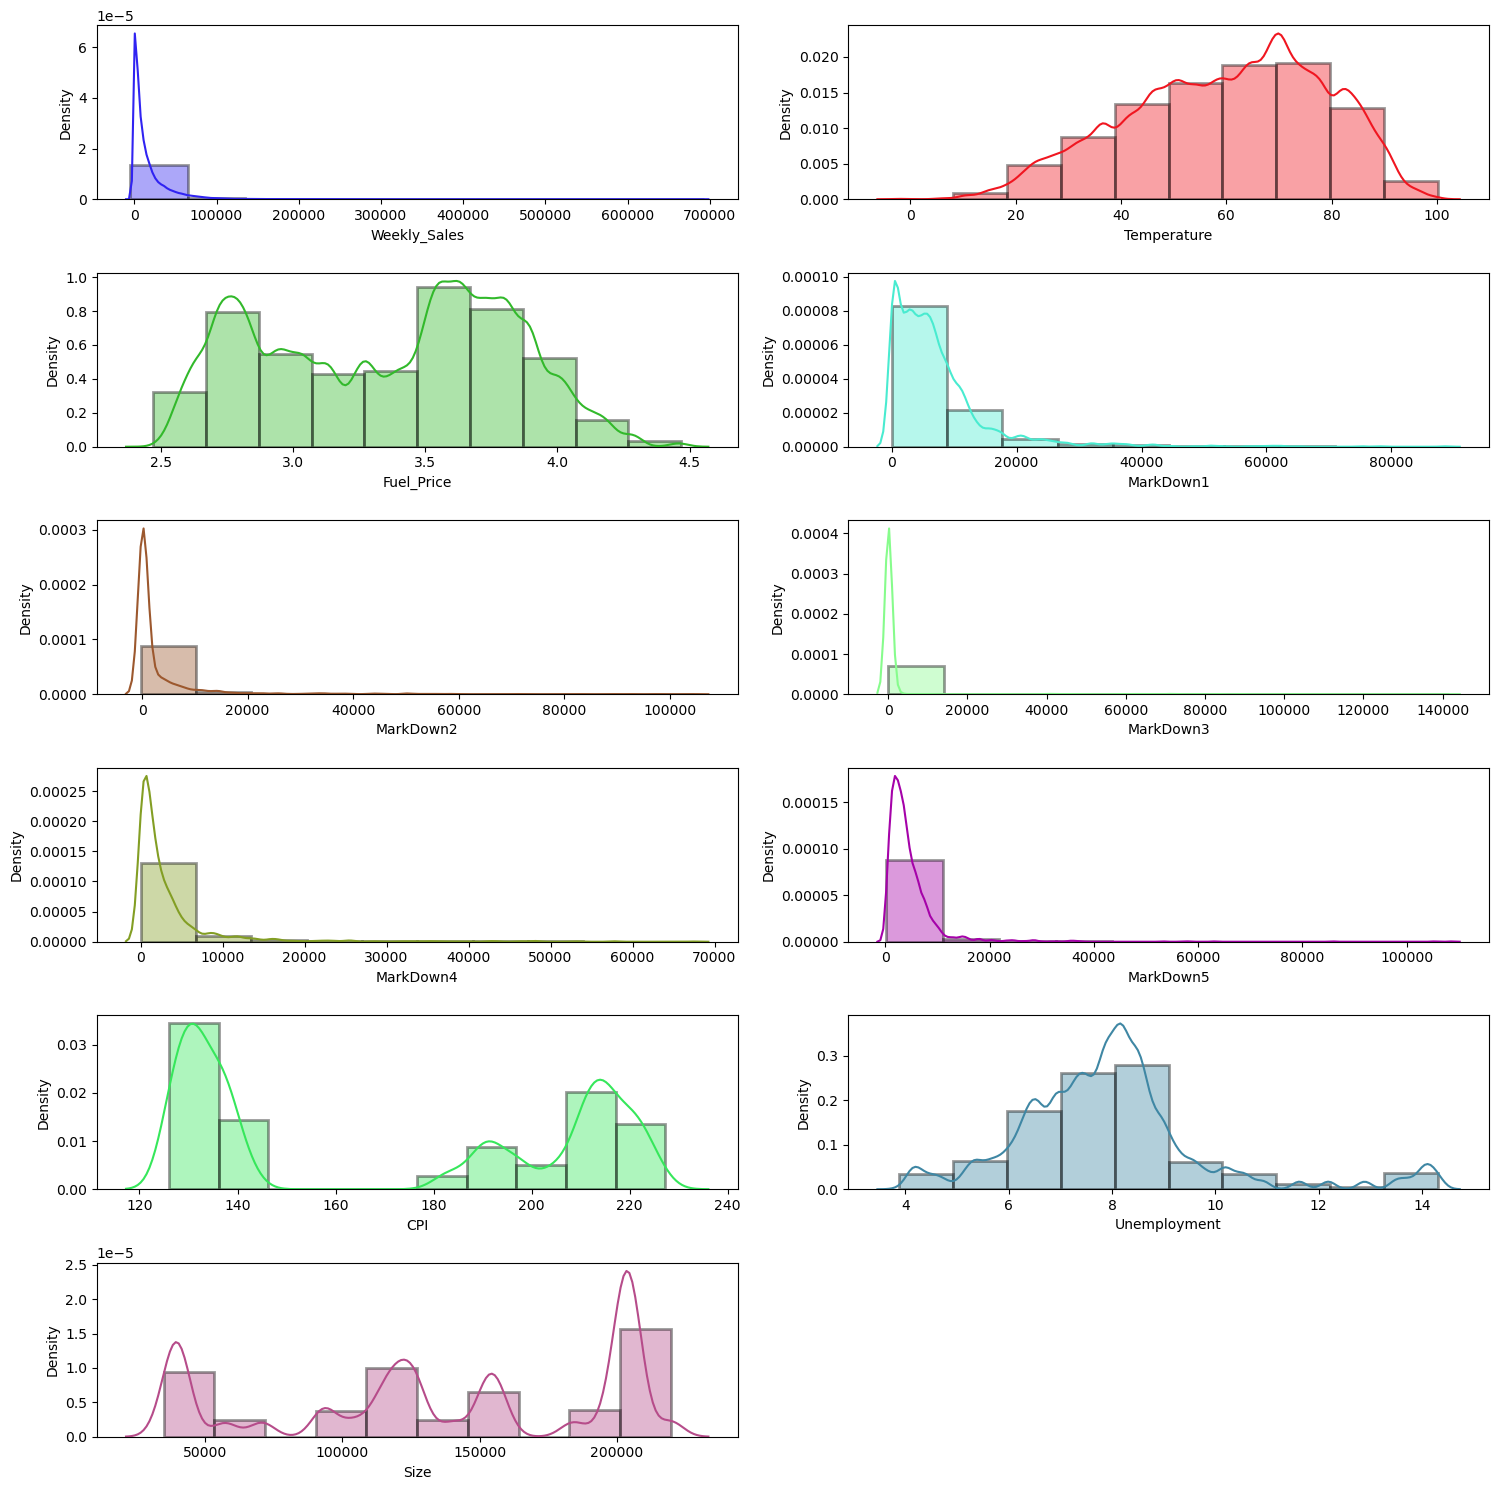

In [46]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

plot_nf=['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
         'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']

plt.figure(figsize=[15,15])

for i in range(len(plot_nf)):
    plt.subplot(6,2,i+1)
    sns.distplot(original_df[plot_nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, 
                 color=list(np.random.randint([255,255,255])/255))

# plt.subplot(6,1,1)
# sns.distplot(original_df[plot_nf[-1]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, 
#              color=list(np.random.randint([255,255,255])/255))  

plt.tight_layout()
plt.show()

**Inference:**

- Temperature and Unemployment data seem to be normally distributed.
- CPI and fuel price data are binormally distributed.
- Rest of the features seem to have a skewed distribution.

                                              Numeric Box Plot Distribution                                               


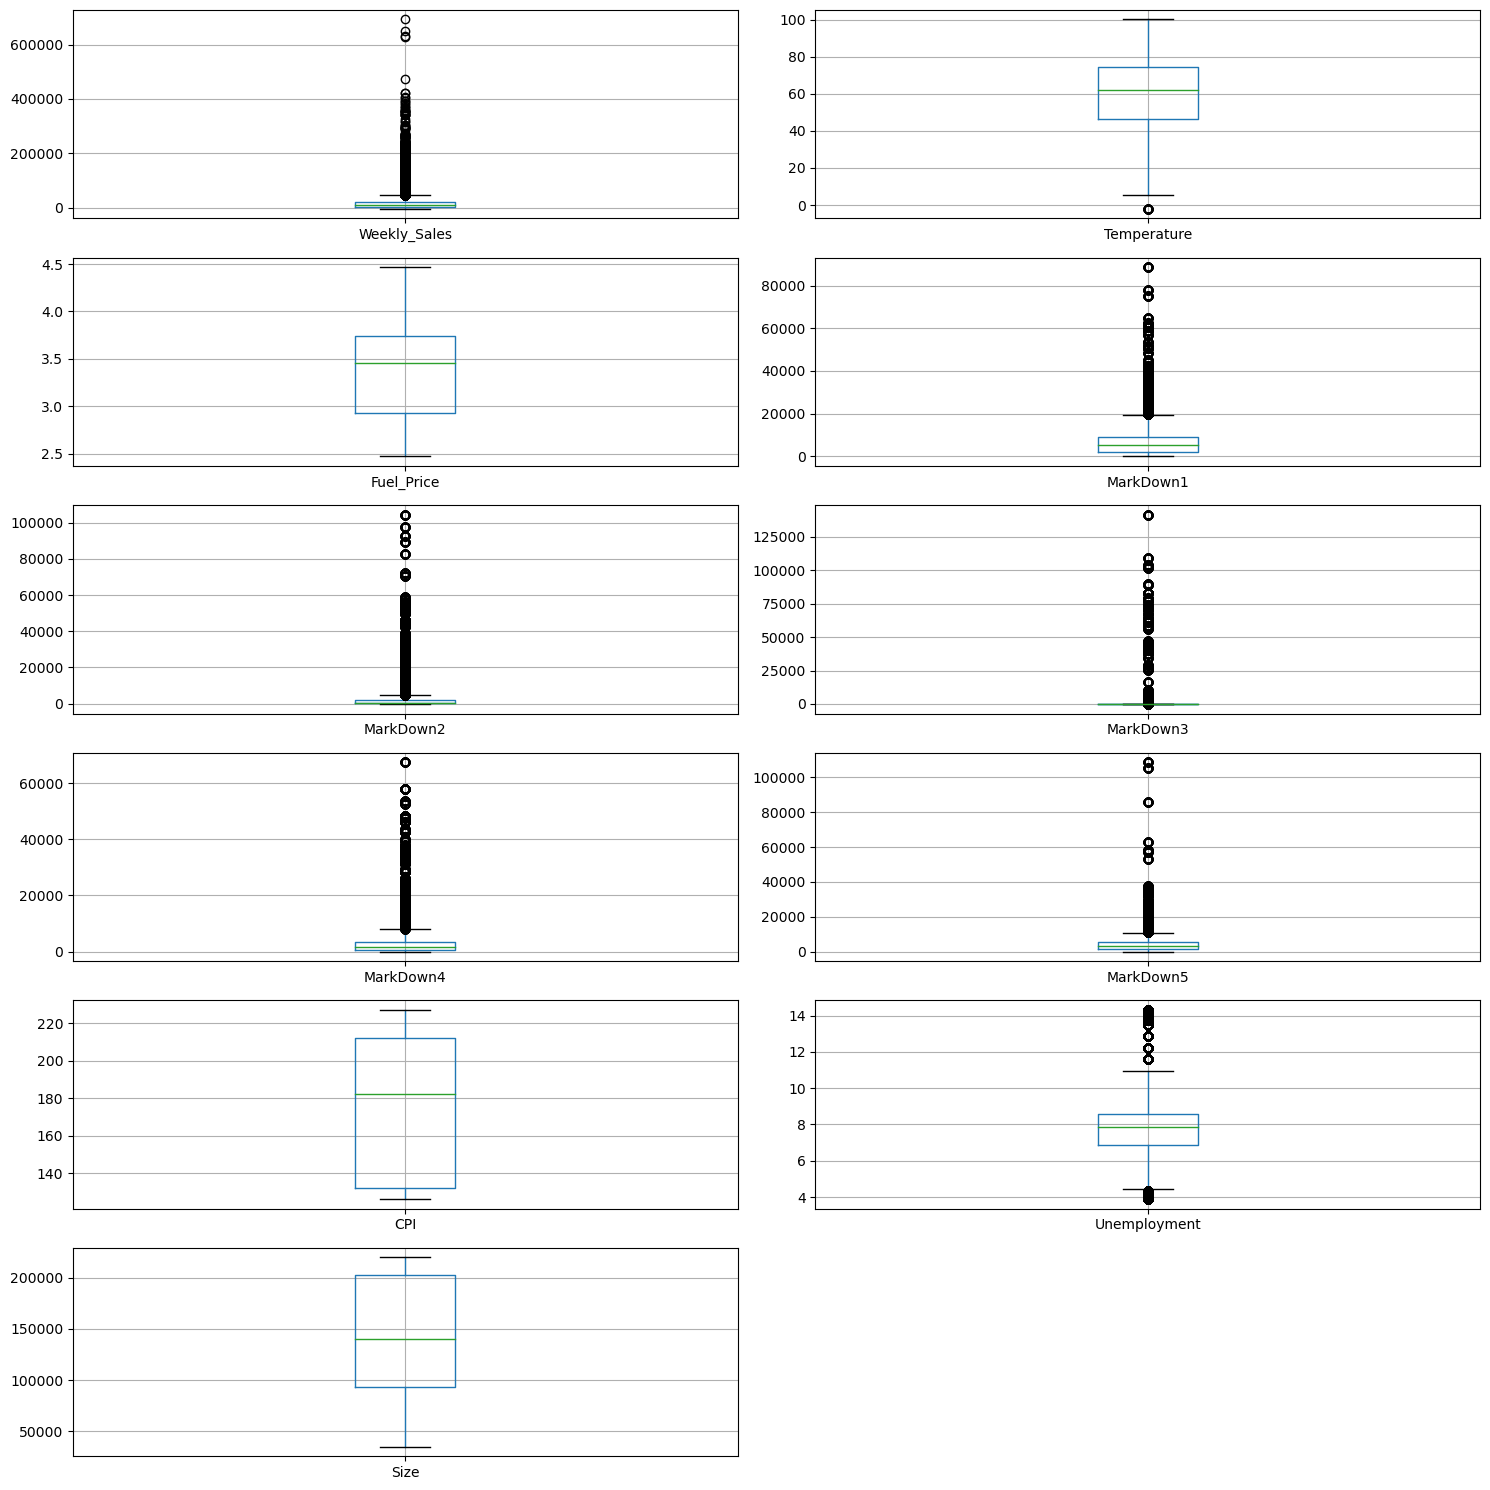

In [47]:
print('\033[1mNumeric Box Plot Distribution\033[0m'.center(130))

plt.figure(figsize=[15,15])

for i in range(len(plot_nf)):
    plt.subplot(6,2,i+1)
    original_df.boxplot(plot_nf[i])
    
# plt.subplot(6,1,1)
# original_df.boxplot(plot_nf[-1])
    
plt.tight_layout()
plt.show()

**Inference:**

- Except CPI, Size, Fuel Price and Temperature, most of the features seem to have many outliers. We will remove these outliers during data cleaning process.

In [49]:
# df_weeks = original_df.groupby(by=['Week']).sum()
weekly_sales = original_df.groupby(['Year','Week'], as_index = False).agg({'Weekly_Sales': ['sum', 'mean', 'median']})
weekly_sales.columns = ['Year', 'Week', 'sum', 'mean', 'median']

In [57]:
weekly_sales.shape[0]
weekly_sales.head(130)

,Year,Week,sum,mean,median
0,2010,1,42239875.87,14391.780535,6940.74
1,2010,5,99341315.76,16935.103266,8390.22
2,2010,7,48276993.78,16216.658979,8411.25
3,2010,8,43968571.13,14899.549688,7235.80
4,2010,10,97103285.49,16528.218807,7885.20
...,...,...,...,...,...
122,2012,41,47403451.04,16030.926967,7557.50
123,2012,42,45122410.57,15295.732397,7374.70
124,2012,43,45544116.29,15391.725681,7547.23
125,2012,45,46925878.99,15784.015806,7533.42


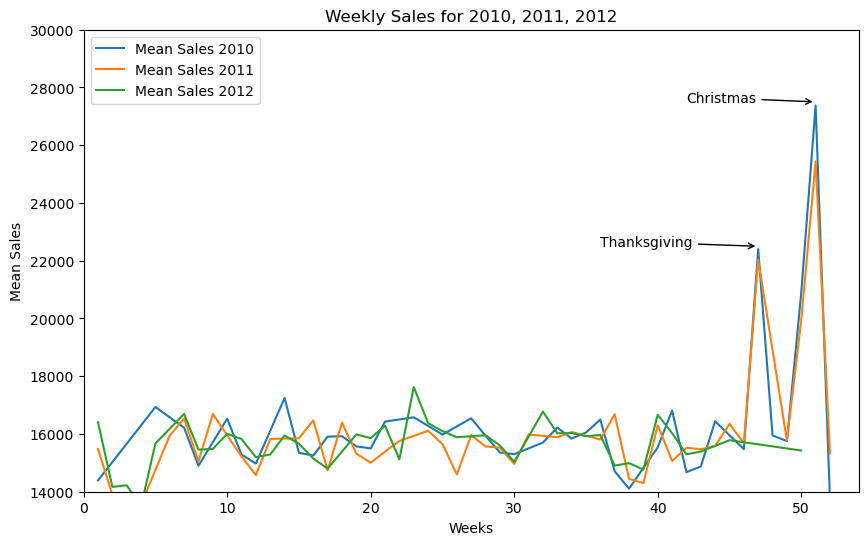

In [58]:
# Create a line plot for each year
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

years = weekly_sales['Year'].unique()
for year in years:
    year_data = weekly_sales[weekly_sales['Year'] == year]
    plt.plot(year_data['Week'], year_data['mean'], label=f'Mean Sales {year}')

plt.xlim(0, 54)    
plt.ylim(14000, 30000)

# Add annotations
plt.annotate("Thanksgiving", xy=(47, 22500), xytext=(36, 22500), arrowprops=dict(arrowstyle="->"), fontsize=10)
plt.annotate("Christmas", xy=(51, 27500), xytext=(42, 27500), arrowprops=dict(arrowstyle="->"), fontsize=10)

# Add labels and title
plt.xlabel('Weeks')
plt.ylabel('Mean Sales')
plt.title('Weekly Sales for 2010, 2011, 2012')
plt.legend(loc='upper left')

# Show the plot
plt.show()

**Inference**:

- The sales trend across weeks is similar for all the 3 years.
- As expected, the sales went up during Christmas and Thanksgiving week.

In [61]:
weekly_markdown=original_df.groupby(['Week'], as_index=False).mean()
all_markdowns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

weekly_markdown['NetMarkDown']=weekly_markdown[all_markdowns].sum(axis=1)

In [65]:
weekly_markdown

,Week,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month,Year,NetMarkDown
0,1,22.247874,44.105187,15438.693561,0.000000,66.998497,3.440807,7304.495617,31.183262,118.307616,1827.804805,3091.389303,171.179029,7.998184,136524.531633,1.000000,2011.000680,12373.180603
1,2,22.232100,44.120292,14030.667886,0.000000,34.612443,3.240301,3438.496251,9856.815354,78.828741,609.575868,3849.031052,170.991001,7.860695,136651.554462,1.000000,2011.503224,17832.747266
2,3,22.125404,44.134933,14077.870442,0.000000,37.867606,3.261392,2436.960760,3320.158912,83.137491,754.782176,2842.179294,171.320752,7.852919,136860.670580,1.000000,2011.503488,9437.218634
3,4,22.137796,44.134049,13530.033667,0.000000,37.698273,3.275299,1496.648699,1782.814017,113.412660,113.207385,2685.466765,171.406934,7.858159,136851.430250,1.000000,2011.502810,6191.549526
4,5,22.177055,44.297877,16508.847192,0.000000,57.858951,3.108531,16660.722836,1632.446612,32.337265,12468.324851,3535.804692,169.849698,8.094999,136975.102868,2.000000,2010.675248,34329.636257
5,6,22.194851,44.411408,15946.017123,0.000000,62.016709,3.523979,4630.538607,105.464073,3589.623724,3121.001309,18683.272846,172.335265,7.907109,136634.451792,2.000000,2011.000000,30129.900558
6,7,22.130362,44.406764,16484.512808,0.000000,40.597291,3.141281,11612.304809,8299.497699,18.819190,7274.530649,6032.310492,170.327203,8.099603,136780.084108,2.000000,2011.003360,33237.462839
7,8,22.145296,44.109905,15136.356574,0.000000,41.824594,3.173113,9435.308801,5928.290868,7.622885,3141.520000,5884.635529,170.492780,8.095561,136904.766169,2.000000,2011.001131,24397.378082
8,9,22.159010,44.431429,16080.285179,0.000000,58.535726,3.644982,38318.227017,3001.690739,150.672909,31502.484083,6241.230860,172.540053,7.790176,136849.790812,3.000000,2011.504662,79214.305608
9,10,22.229360,44.293146,16352.542982,0.000000,65.736727,3.069362,21123.801621,147.817847,33.697585,11968.940803,3495.155416,170.394902,8.011686,136673.748134,3.000000,2010.671115,36769.413272


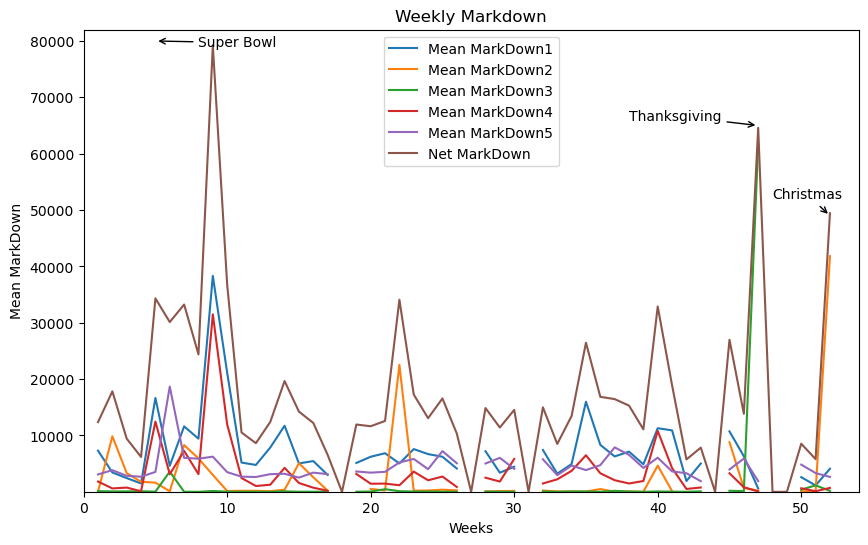

In [60]:
# Create a line plot for each year
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

all_markdowns==['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for markdown in all_markdowns:
    plt.plot(weekly_markdown['Week'], weekly_markdown[markdown], label=f'Mean {markdown}')

plt.plot(weekly_markdown['Week'], weekly_markdown['NetMarkDown'], label='Net MarkDown')
plt.xlim(0, 54)    
plt.ylim(22, 82000) #65000

# Add annotations
plt.annotate("Thanksgiving", xy=(47, 65000), xytext=(38, 66000), arrowprops=dict(arrowstyle="->"), fontsize=10) #62000
plt.annotate("Christmas", xy=(52, 49000), xytext=(48, 52000), arrowprops=dict(arrowstyle="->"), fontsize=10)    #42000
plt.annotate("Super Bowl", xy=(5, 80000), xytext=(8, 79000), arrowprops=dict(arrowstyle="->"), fontsize=10)     #38000

# Add labels and title
plt.xlabel('Weeks')
plt.ylabel('Mean MarkDown')
plt.title('Weekly Markdown')
plt.legend(loc='upper center')

# Show the plot
plt.show()

In [66]:
corr_df=original_df[original_df['Date'] >= '2011-12-01'] #[all_markdowns+['Weekly_Sales']]
corr_df['NetMarkDown']=corr_df[all_markdowns].sum(axis=1)
corr_df=corr_df.corr()
corr_df['Weekly_Sales'][all_markdowns+['NetMarkDown']]

MarkDown1      0.090687
MarkDown2      0.024738
MarkDown3      0.087371
MarkDown4      0.049219
MarkDown5      0.090143
NetMarkDown    0.105740
Name: Weekly_Sales, dtype: float64

**Inference:**

- The net markdown is highest in the 5th, 47th and 52nd week.
- The 5th week is close to SuperBowl week while 47th and 52nd week are Thanksgiving and Christmas weeks respectively.
- There's a small peak in the 32nd week. 
- There's no strong correlation between weekly sales and markdown.

In [68]:
cat_features=['Store', 'Dept', 'Type', 'Year', 'IsHoliday']
temp=cat_features+['Date','Weekly_Sales']
num_features=[col for col in original_df.columns if col not in temp]


In [71]:
num_features

['Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size',
 'Week',
 'Month']

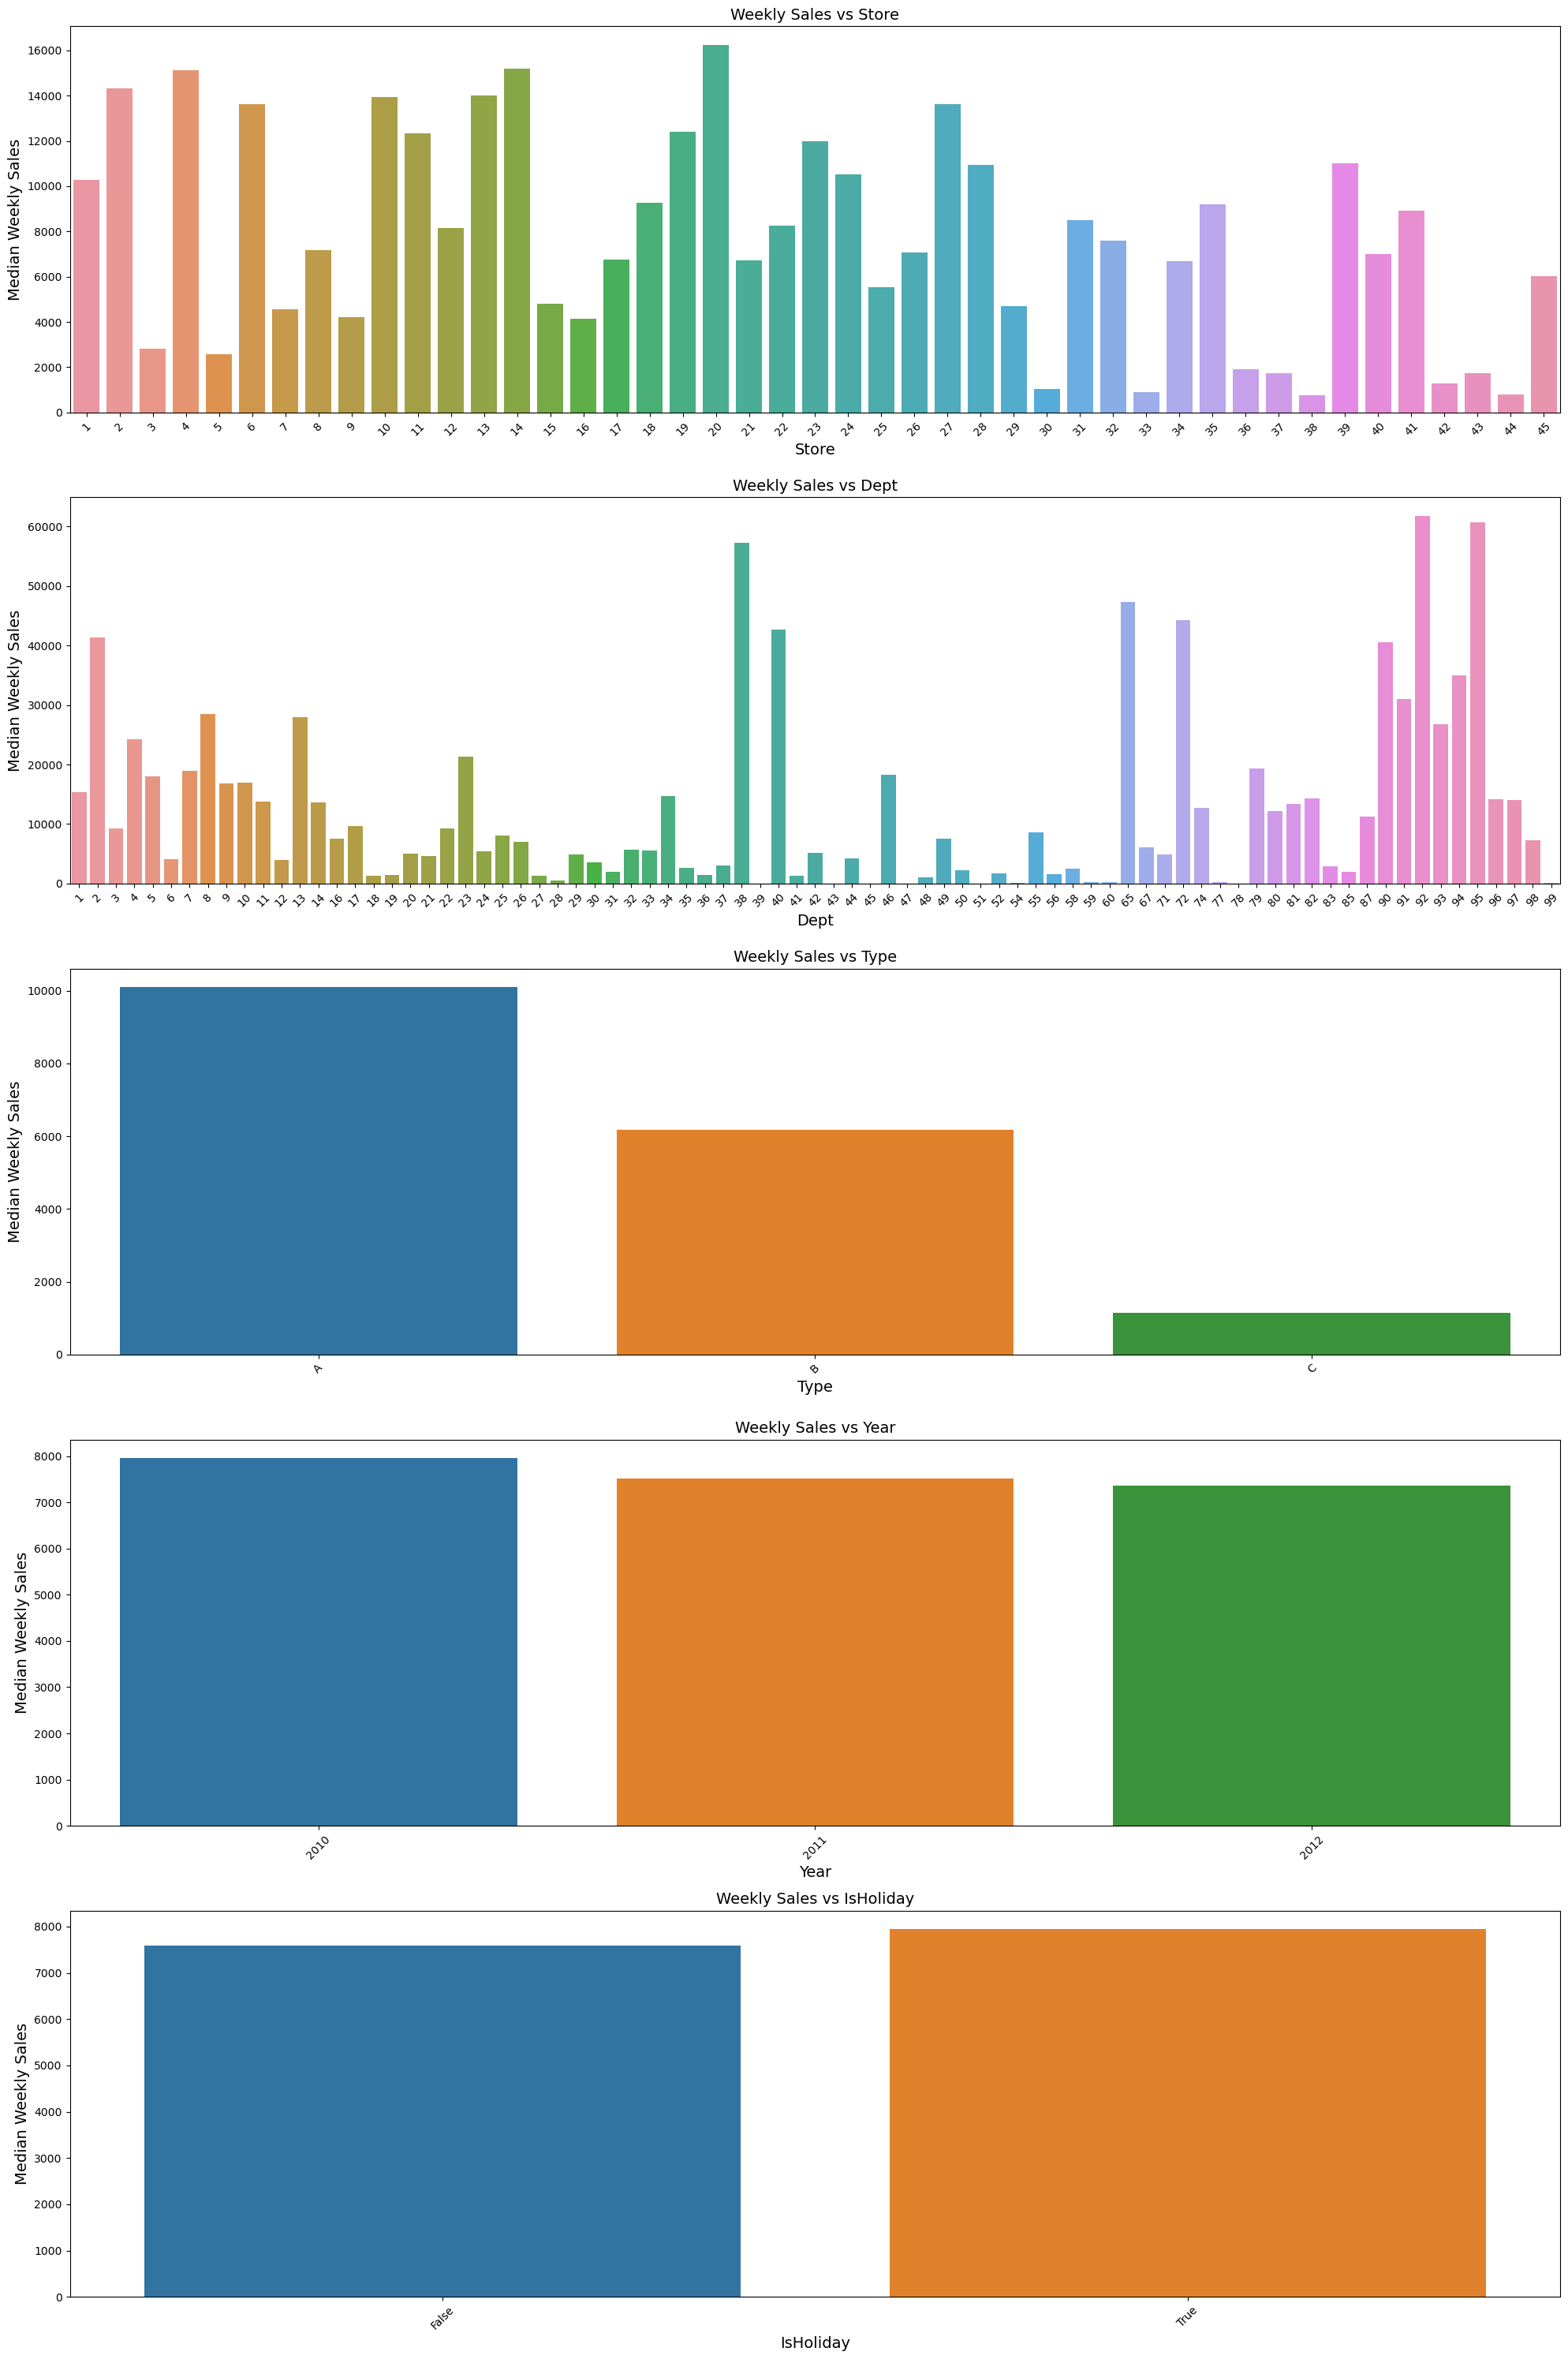

In [72]:
plt.figure(figsize=(20, 30))  # Adjust the figure size as needed

for i, feature in enumerate(cat_features):
    
    plt.subplot(5,1,i+1)
    
    # Calculate the median for each category
    median_values = original_df.groupby(feature)['Weekly_Sales'].median().reset_index()
    sns.barplot(x=feature, y='Weekly_Sales', data=median_values, ci=None)
    
    # sns.barplot(x=feature, y='Weekly_Sales', data=original_df, ci=None) 
    plt.title(f'Weekly Sales vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Median Weekly Sales', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
plt.tight_layout()
plt.show()

**Inference:**

- The weekly sales vary hugely across the departments and stores. 
- Type A stores have the highest weekly sales followed by Type B and Type C stores.
- Special holiday weeks saw a slightly higher sale.

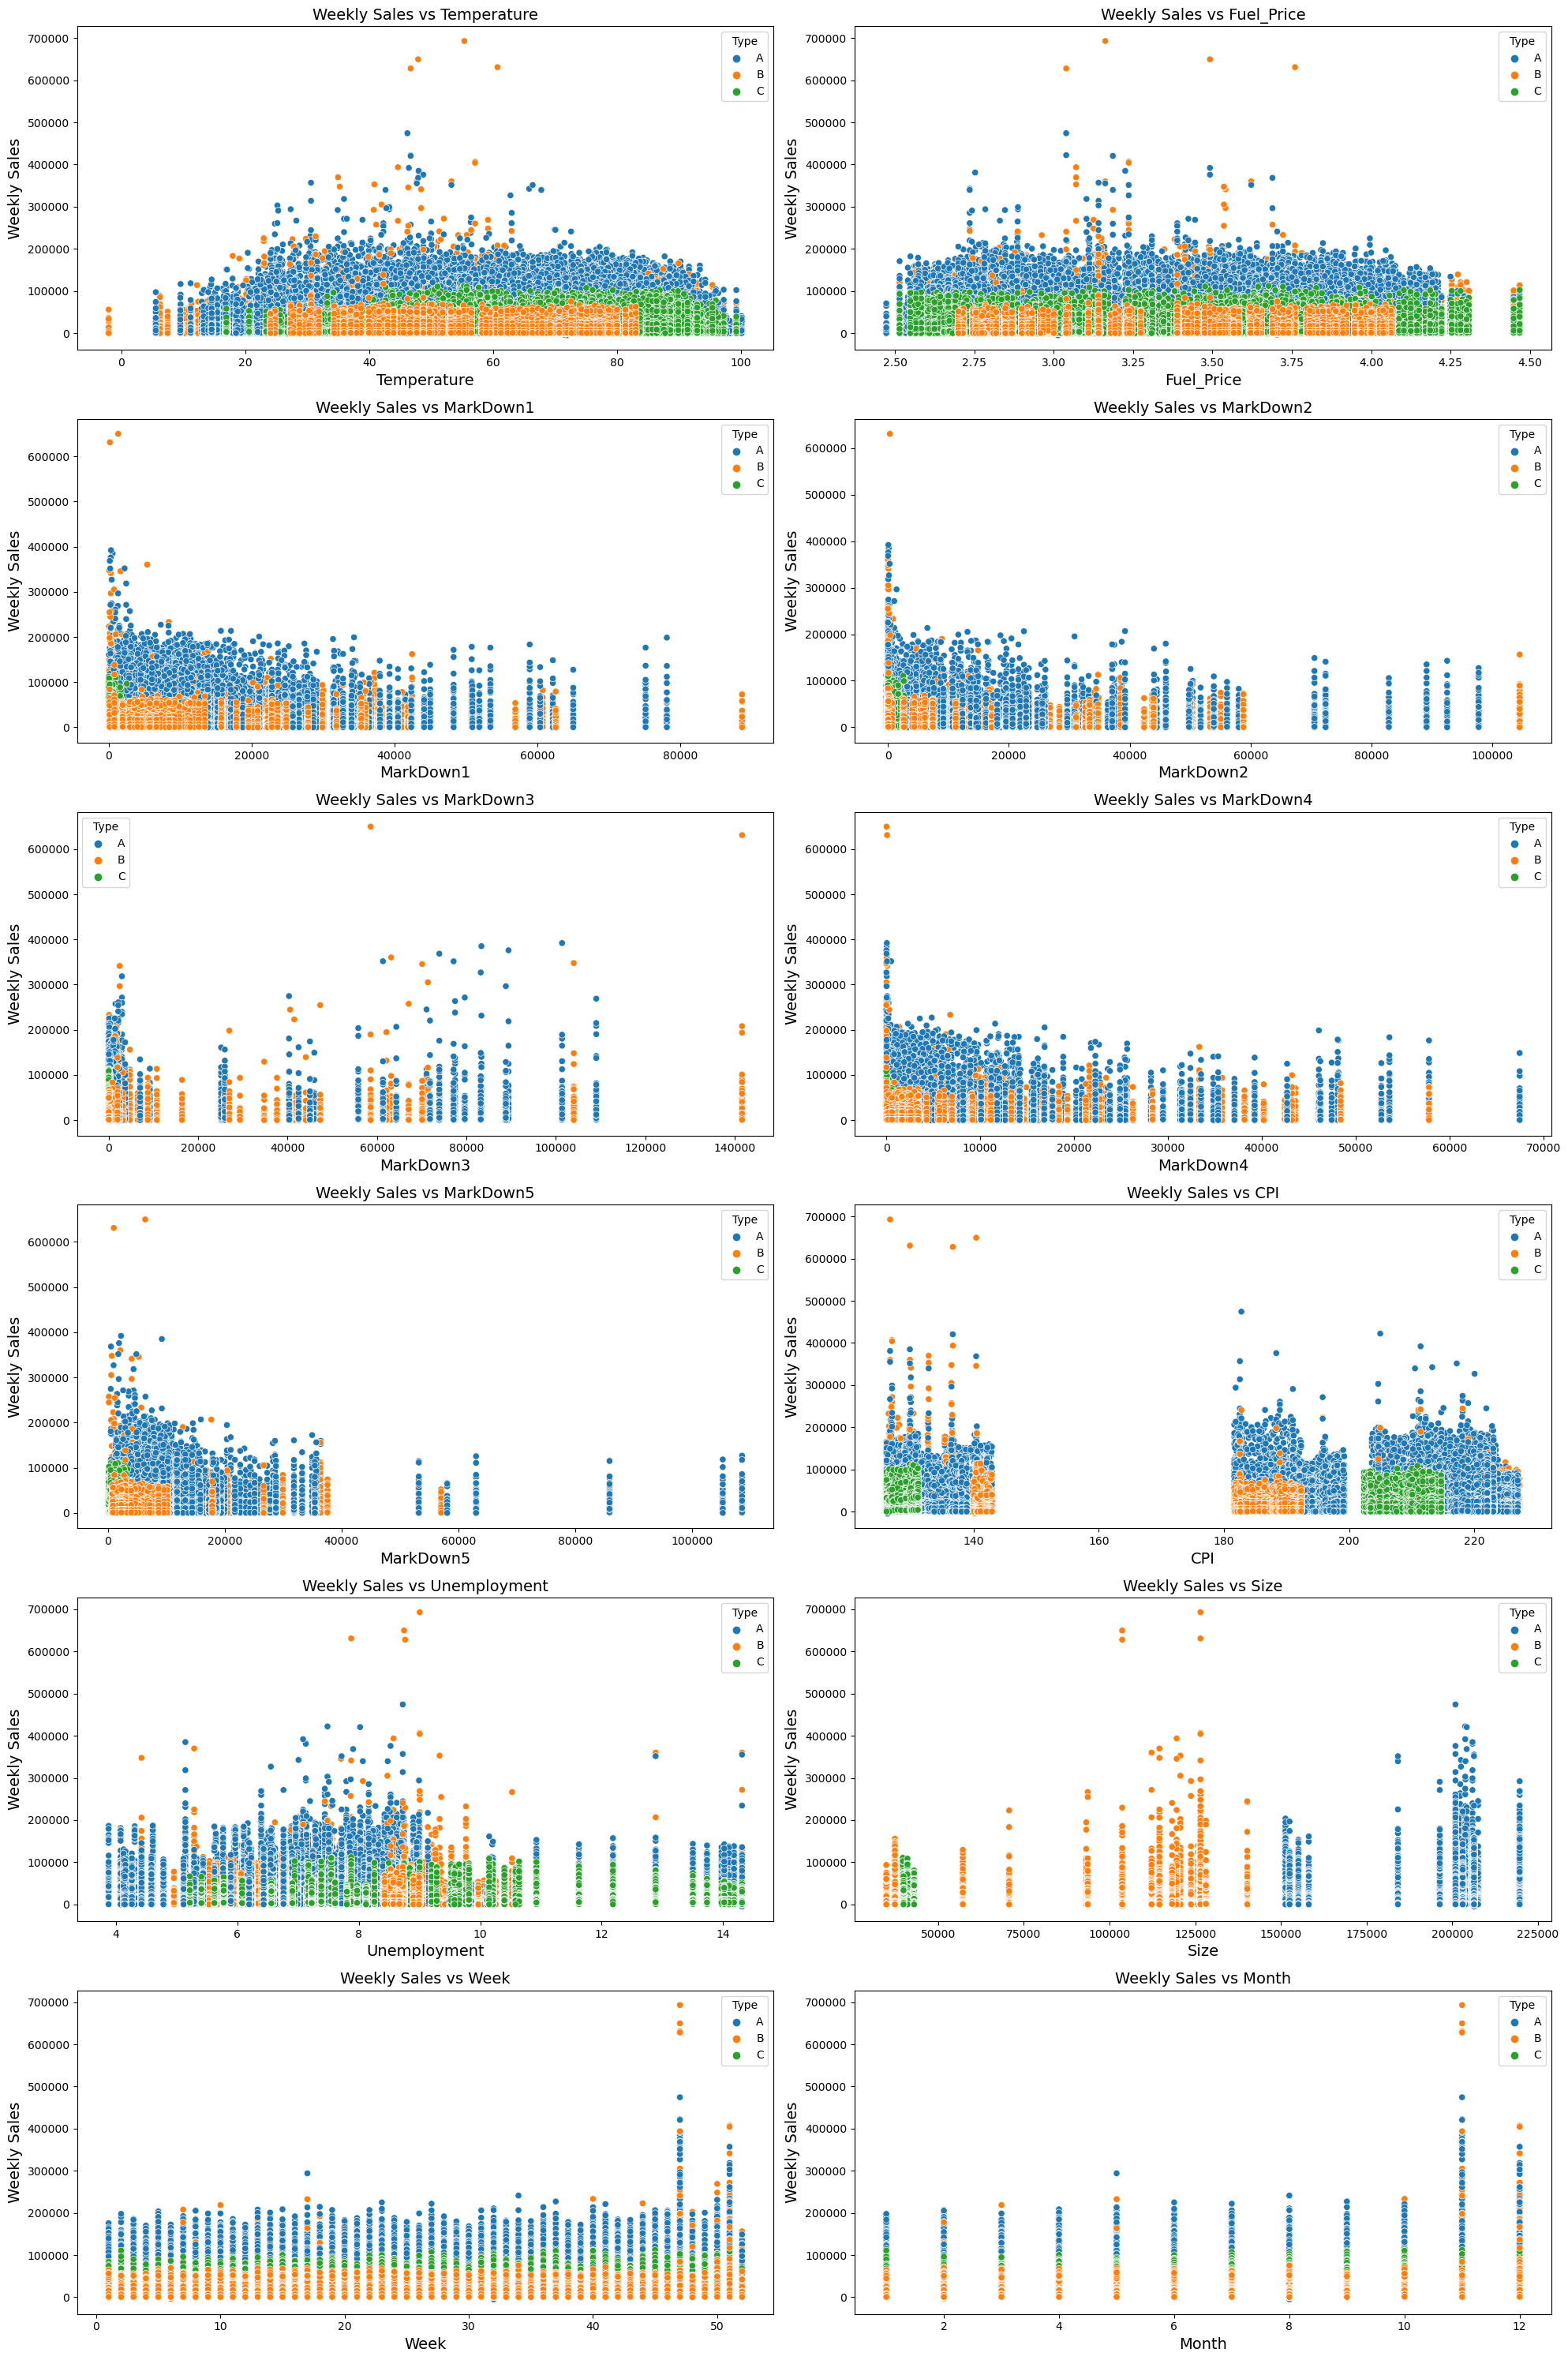

In [73]:
plt.figure(figsize=(20, 30))  # Adjust the figure size as needed
nrwos = int(np.ceil(len(num_features)/2))

for i, feature in enumerate(num_features):
    plt.subplot(nrwos,2,i+1)
    # Create scatter plot with 'Type' as hue
    sns.scatterplot(x=feature, y='Weekly_Sales', hue='Type', data=original_df)
    plt.title(f'Weekly Sales vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Weekly Sales', fontsize=14)
    plt.legend(title='Type')

plt.tight_layout()
plt.show()

**Inference:**

- None of the numerical features tend to show a clear pattern with respect to weekly sales.

In [74]:
original_df[['Size', 'Week', 'Month']].nunique()

Size     40
Week     52
Month    12
dtype: int64

`Size`, `Month` and `Week` have a limited set of values. So, we will group the weekly sales by these values and take the median so as to ascertain how the weekly sales vary with these features.

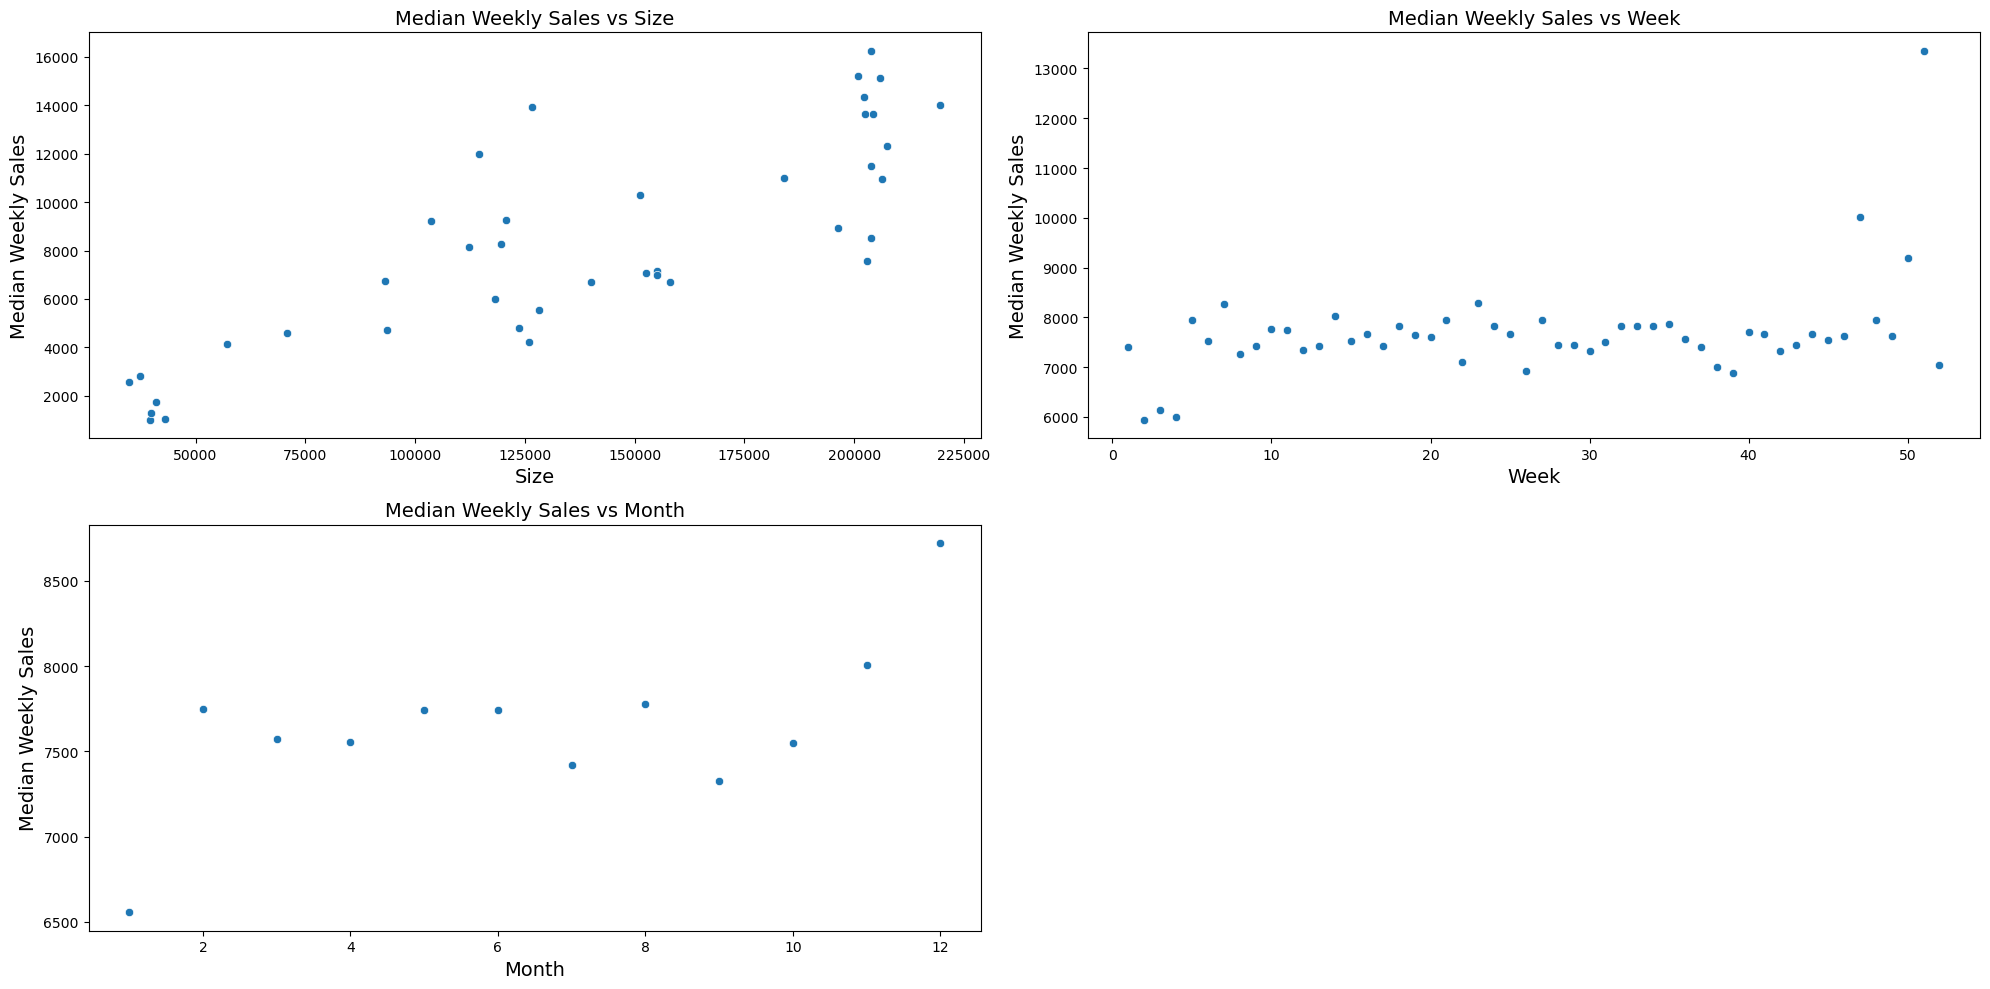

In [75]:
# nf_df=original_df.groupby(['Month'], as_index = False).agg({'Weekly_Sales':['median']})
# nf_df.columns=['Month', 'Median_Weekly_Sales']
num_features1=['Size', 'Week', 'Month']
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
nrwos = int(np.ceil(len(num_features1)/2))

for i, feature in enumerate(num_features1):
    nf_df=original_df.groupby([feature], as_index = False).agg({'Weekly_Sales':['median']})
    nf_df.columns=[feature, 'Median_Weekly_Sales']
    
    plt.subplot(nrwos,2,i+1)
    # Create scatter plot with 'Type' as hue
    sns.scatterplot(x=feature, y='Median_Weekly_Sales', data=nf_df)
    plt.title(f'Median Weekly Sales vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Median Weekly Sales', fontsize=14)
    
plt.tight_layout()
plt.show()

**Inference:**

- As the store size increases, the weekly sales also tend to increase.
- The weekly sales saw a jump near the end weeks(and hence months) of a year.

## 4. Data Cleaning

In [141]:
df=original_df.copy() #Making a copy of the original dataframe before preprocessing

In [142]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2010-01-10,20094.19,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,A,151315,1,1,2010
1,1,1,2010-02-04,57258.43,False,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,A,151315,5,2,2010
2,1,1,2010-02-07,16333.14,False,80.91,2.669,NaN,NaN,NaN,NaN,NaN,211.223533,7.787,A,151315,5,2,2010
3,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2,2010
4,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-10-08,727.49,False,78.65,3.722,17868.84,50.60,57.66,2593.93,1890.59,191.162613,8.684,B,118221,41,10,2012
421566,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,10,2012
421567,45,98,2012-10-26,1076.80,False,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,43,10,2012
421568,45,98,2012-11-05,893.60,False,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,B,118221,45,11,2012


### Removing duplicate rows, handling null values and eliminating rows with negative weekly sales

In [143]:
neg_sales=df[df['Weekly_Sales']<0].shape[0] 
print(f"There are {neg_sales} rows with negative weekly sales.")

There are 1285 rows with negative weekly sales.


In [144]:
#Removing the rows with negative sales

df = df[df['Weekly_Sales']>=0]

In [81]:
#Removal of any Duplicate rows (if any)

counter = 0
nr,nc = df.shape

df.drop_duplicates(inplace=True)

if df.shape==(nr, nc):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {nr-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [145]:
#Check for empty elements

null_cols = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
null_cols['Percentage'] = round(null_cols['Total Null Values']/df.shape[0],3)*100
print(null_cols)

              Total Null Values  Percentage
Store                         0         0.0
Week                          0         0.0
Size                          0         0.0
Type                          0         0.0
Unemployment                  0         0.0
CPI                           0         0.0
Month                         0         0.0
Year                          0         0.0
Fuel_Price                    0         0.0
Temperature                   0         0.0
IsHoliday                     0         0.0
Weekly_Sales                  0         0.0
Date                          0         0.0
Dept                          0         0.0
MarkDown5                269337        64.1
MarkDown1                270085        64.3
MarkDown3                283618        67.5
MarkDown4                285750        68.0
MarkDown2                309367        73.6


                                       Correlation Matrix                                       


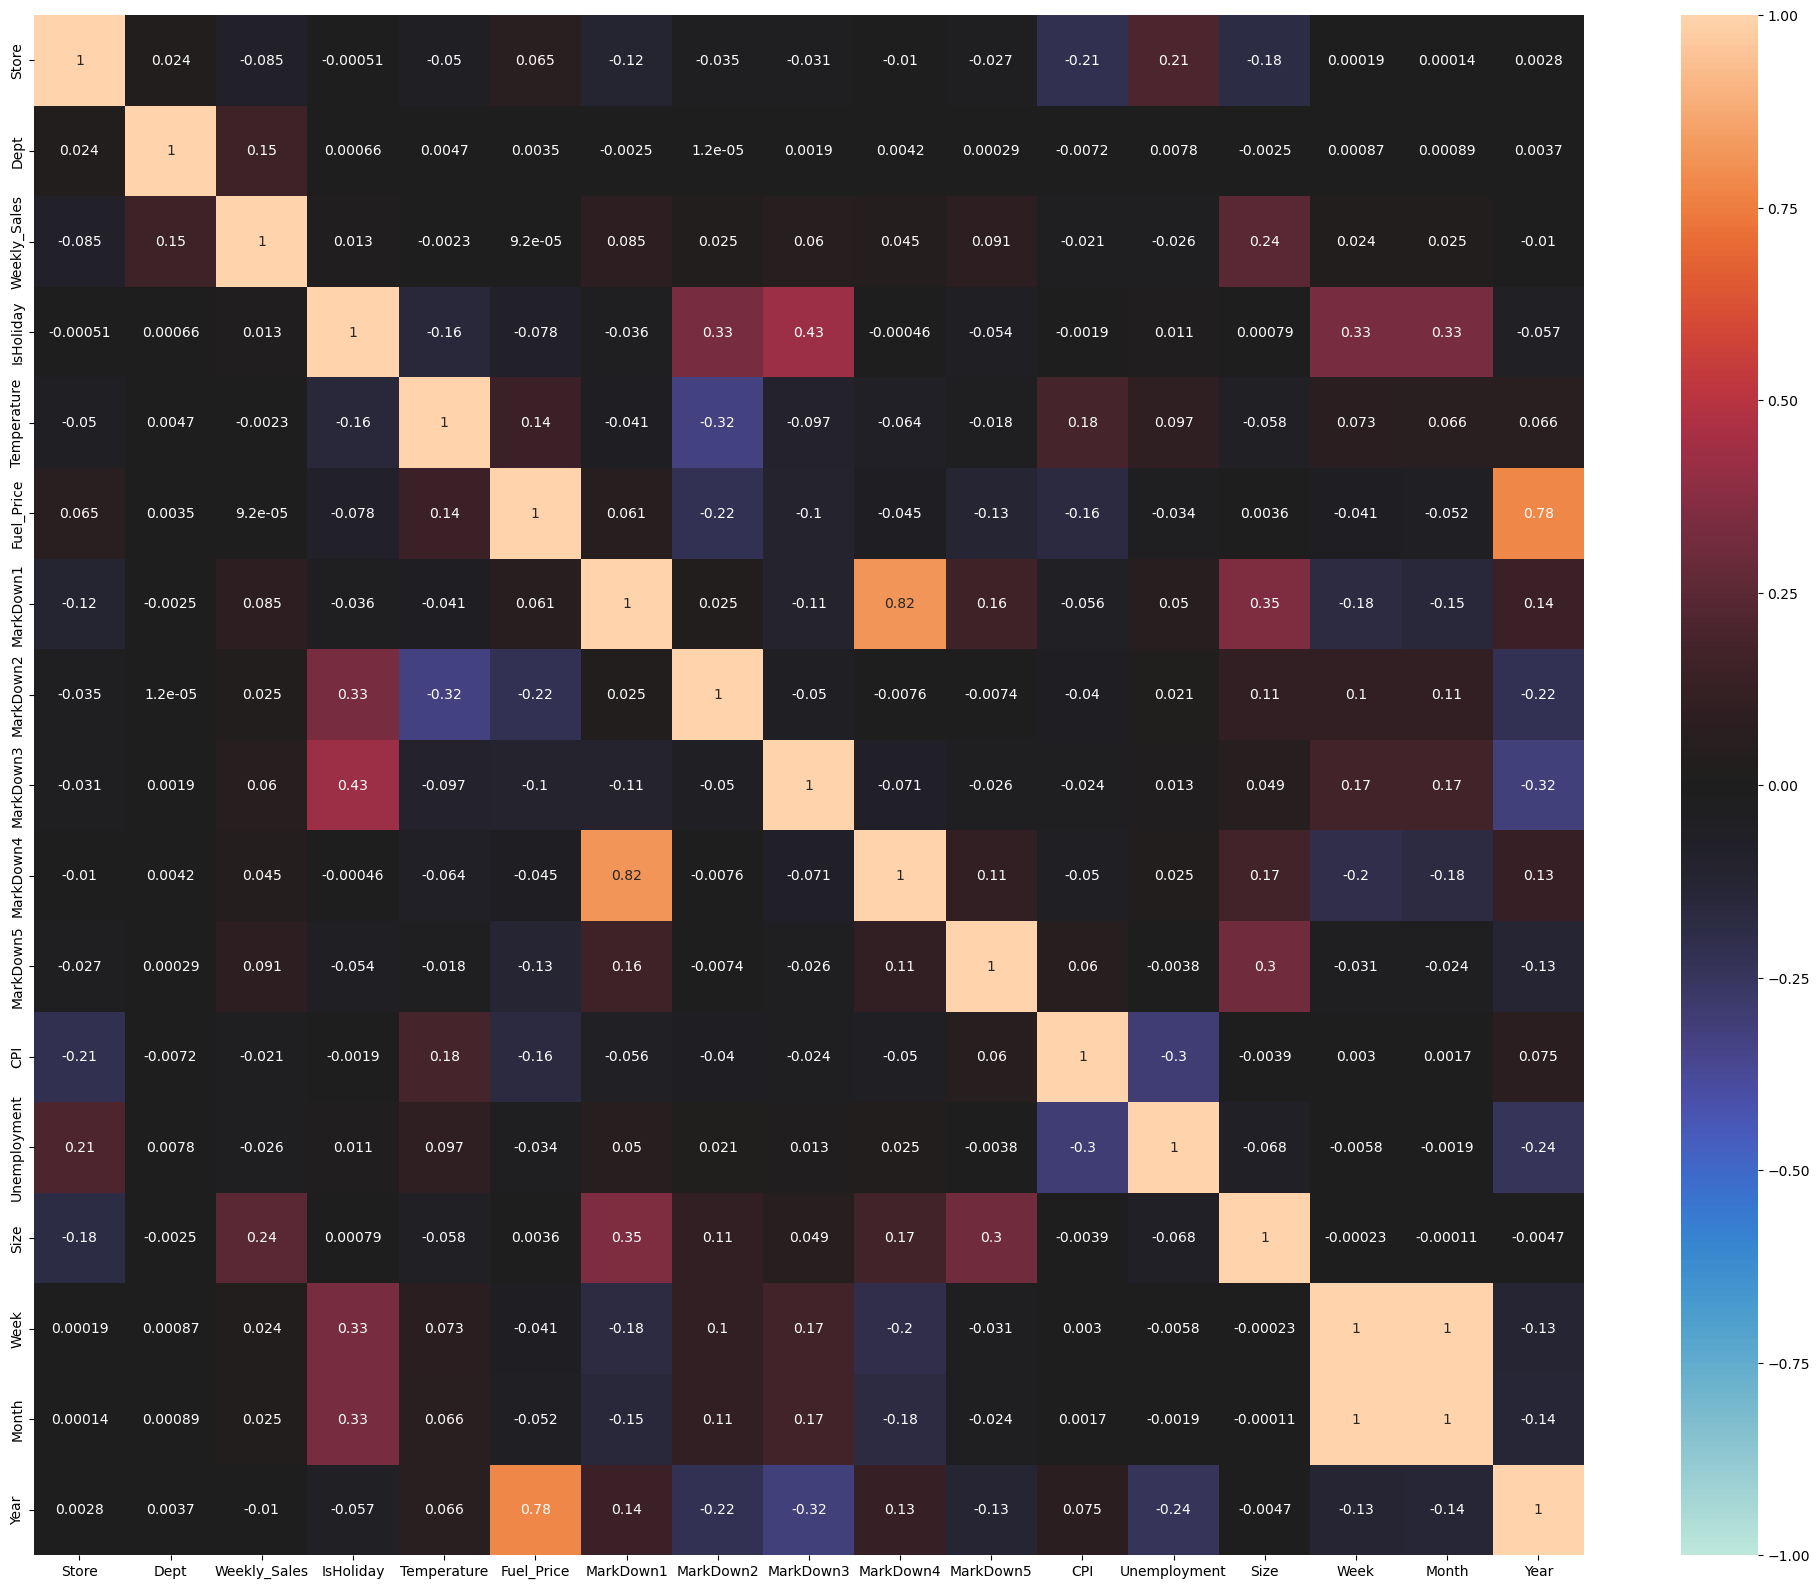

In [146]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

Markdown columns have anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

None of the Markdown data shows strong correlation with Weekly Sales. So, instead of handling the missing the values, we would go ahead with dropping those columns.

Also, Month and Week seem to be highly correlated. Since week offers more granularity, we would drop the Month column.

In [147]:
# Dropping the Markdown columns and month column

df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Month'], inplace=True, axis=1)

## 5. Feature Engineering

### 5.1. Adding new feature columns to take Thanksgiving and Christmas into account

In [150]:
df['ThanksgivingWeek'] = df['Week'].apply(lambda x: 1 if x == 47 else 0)
df['ChristmasWeek'] = df['Week'].apply(lambda x: 1 if x == 51 else 0)
df['Super_Bowl']=df['Week'].apply(lambda x: 1 if x==5 else 0)

In [155]:
# Dropping the date column

df.drop(['Date','CPI'], axis=1 , inplace=True)

In [156]:
df

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Unemployment,Type,Size,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
0,1,1,20094.19,False,71.89,7.838,A,151315,1,2010,0,0,0
1,1,1,57258.43,False,62.27,7.808,A,151315,5,2010,0,0,1
2,1,1,16333.14,False,80.91,7.787,A,151315,5,2010,0,0,1
3,1,1,41595.55,False,39.93,8.106,A,151315,7,2010,0,0,0
4,1,1,19403.54,False,46.63,8.106,A,151315,8,2010,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,727.49,False,78.65,8.684,B,118221,41,2012,0,0,0
421566,45,98,760.01,False,56.47,8.667,B,118221,42,2012,0,0,0
421567,45,98,1076.80,False,58.85,8.667,B,118221,43,2012,0,0,0
421568,45,98,893.60,False,61.24,8.567,B,118221,45,2012,0,0,0


### 5.2. Encoding categorical data

In [158]:
df.nunique()

Store                   45
Dept                    81
Weekly_Sales        358786
IsHoliday                2
Temperature           3528
Unemployment           349
Type                     3
Size                    40
Week                    52
Year                     3
ThanksgivingWeek         2
ChristmasWeek            2
Super_Bowl               2
dtype: int64

In [160]:
df['IsHoliday'].unique()

array([False,  True])

In [161]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

In [165]:
df['IsHoliday']=encoder.fit_transform(df[['IsHoliday']])

In [166]:
df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [167]:
df['Type']=encoder.fit_transform(df[['Type']])

In [168]:
df.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Unemployment', 'Type', 'Size', 'Week', 'Year', 'ThanksgivingWeek',
       'ChristmasWeek', 'Super_Bowl'],
      dtype='object')

## 6. Removing Outliers 

In [169]:
non_enc_features=['Weekly_Sales','Unemployment']

In [170]:
#Removal of outlier:

for i in non_enc_features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df = df[df[i] <= (Q3+(1.5*IQR))]
    df = df[df[i] >= (Q1-(1.5*IQR))]
    df = df.reset_index(drop=True)
    
display(df.describe())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers and duplicate rows, the dataset had {} samples.'.format(original_df.shape[0]))
print('After removal of outliers and duplicate rows, the dataset has {} samples.'.format(df.shape[0]))

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Unemployment,Type,Size,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
count,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000,355283.000000
mean,22.183969,42.823653,10529.782481,0.070462,59.624471,7.705604,0.598543,133927.548363,26.044134,2010.957037,0.013792,0.013026,0.020772
std,12.871961,29.578223,11270.057836,0.255925,18.491070,1.235814,0.657380,60925.515718,14.509166,0.793620,0.116626,0.113387,0.142621
min,1.000000,1.000000,0.000000,0.000000,-2.060000,4.420000,0.000000,34875.000000,1.000000,2010.000000,0.000000,0.000000,0.000000
25%,11.000000,18.000000,1810.410000,0.000000,46.100000,6.885000,0.000000,93188.000000,14.000000,2010.000000,0.000000,0.000000,0.000000
50%,22.000000,35.000000,6366.400000,0.000000,61.740000,7.838000,1.000000,128107.000000,26.000000,2011.000000,0.000000,0.000000,0.000000
75%,33.000000,71.000000,15772.890000,0.000000,74.020000,8.494000,1.000000,202307.000000,38.000000,2012.000000,0.000000,0.000000,0.000000
max,45.000000,99.000000,47494.530000,1.000000,100.140000,10.926000,2.000000,219622.000000,52.000000,2012.000000,1.000000,1.000000,1.000000



Inference:
Before removal of outliers and duplicate rows, the dataset had 421570 samples.
After removal of outliers and duplicate rows, the dataset has 355283 samples.


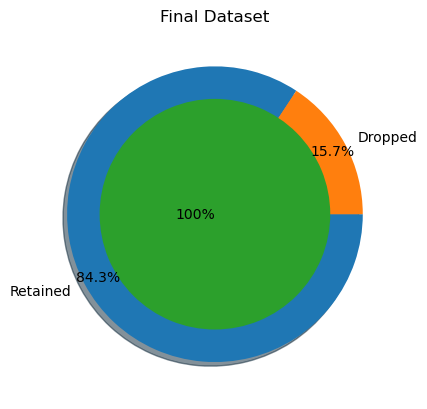


Inference: After the cleanup process, 66287 samples were dropped, while retaining 84.28% of the data.


In [171]:
#Final Dataset size after performing Preprocessing

df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(df.shape[0]*100/(original_df.shape[0]),2)}% of the data.')

# 7. Data Manipulation

In [174]:
#Splitting the data intro training & testing sets

X = df.drop('Weekly_Sales',axis=1)
Y = df['Weekly_Sales']


In [176]:
X

,Store,Dept,IsHoliday,Temperature,Unemployment,Type,Size,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
0,1,1,0.0,71.89,7.838,0.0,151315,1,2010,0,0,0
1,1,1,0.0,80.91,7.787,0.0,151315,5,2010,0,0,1
2,1,1,0.0,39.93,8.106,0.0,151315,7,2010,0,0,0
3,1,1,0.0,46.63,8.106,0.0,151315,8,2010,0,0,0
4,1,1,0.0,81.21,7.787,0.0,151315,10,2010,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
355278,45,98,0.0,78.65,8.684,1.0,118221,41,2012,0,0,0
355279,45,98,0.0,56.47,8.667,1.0,118221,42,2012,0,0,0
355280,45,98,0.0,58.85,8.667,1.0,118221,43,2012,0,0,0
355281,45,98,0.0,61.24,8.567,1.0,118221,45,2012,0,0,0


In [178]:
Y

0         20094.19
1         16333.14
2         41595.55
3         19403.54
4         16241.78
            ...   
355278      727.49
355279      760.01
355280     1076.80
355281      893.60
355282     1061.02
Name: Weekly_Sales, Length: 355283, dtype: float64

In [179]:
def model_regression(x,y,algorithm):
    for i in algorithm:
        xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=100)
        model=i().fit(xtrain,ytrain)
        y_train_pred=model.predict(xtrain)
        y_test_pred=model.predict(xtest)
        training=r2_score(y_train_pred,ytrain)
        testing=r2_score(y_test_pred,ytest)
        data = {'Algorithm':i.__name__, 'Training R2 Score':training,'Testing R2 Score':testing}

        print(data)
        

In [182]:
model_regression(X,Y,[DecisionTreeRegressor,ExtraTreesRegressor,RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,XGBRegressor])

{'Algorithm': 'DecisionTreeRegressor', 'Training R2 Score': 1.0, 'Testing R2 Score': 0.9292186840242256}
{'Algorithm': 'ExtraTreesRegressor', 'Training R2 Score': 0.9999999997416357, 'Testing R2 Score': 0.9568683348705824}
{'Algorithm': 'RandomForestRegressor', 'Training R2 Score': 0.9942045008761822, 'Testing R2 Score': 0.9585663965687548}
{'Algorithm': 'AdaBoostRegressor', 'Training R2 Score': -3.1166003662757094, 'Testing R2 Score': -3.128772642608503}
{'Algorithm': 'GradientBoostingRegressor', 'Training R2 Score': 0.10002069422164639, 'Testing R2 Score': 0.10746488795022491}
{'Algorithm': 'XGBRegressor', 'Training R2 Score': 0.90713800832228, 'Testing R2 Score': 0.9054290023122901}


In [184]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=100)

model = ExtraTreesRegressor().fit(xtrain, ytrain)

y_pred_train = model.predict(xtrain)

y_pred_test = model.predict(xtest)

r2_train = r2_score(ytrain, y_pred_train)

r2_test = r2_score(ytest, y_pred_test)

r2_train, r2_test


(0.9999999998818224, 0.958783590387692)

In [186]:
y_pred_test.shape

(71057,)

In [187]:
test=X.copy()

In [195]:
data = pd.read_csv("C:\\Users\\DINESH KUMAR\\Downloads\\walmart data\\test.csv")
data.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [196]:
features = pd.read_csv("C:\\Users\\DINESH KUMAR\\Downloads\\Features_data_set.csv")
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [197]:
stores = pd.read_csv("C:\\Users\\DINESH KUMAR\\Downloads\\stores_data_set.csv")
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


In [200]:
data = data.merge(stores, how = 'left').merge(features, how = 'left')
data.head(3)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2012-11-09,False,A,151315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2012-11-16,False,A,151315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
#remove unnecessary features
#data.drop(['Date','CPI','Unemployment','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1, inplace = True)

In [207]:
data

,Store,Dept,IsHoliday,Type,Size,Temperature
0,1,1,False,A,151315,NaN
1,1,1,False,A,151315,NaN
2,1,1,False,A,151315,NaN
3,1,1,True,A,151315,NaN
4,1,1,False,A,151315,NaN
...,...,...,...,...,...,...
115059,45,98,False,B,118221,NaN
115060,45,98,False,B,118221,NaN
115061,45,98,False,B,118221,NaN
115062,45,98,False,B,118221,NaN


In [208]:
test.head(3)

,Store,Dept,IsHoliday,Temperature,Unemployment,Type,Size,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
0,1,1,0.0,71.89,7.838,0.0,151315,1,2010,0,0,0
1,1,1,0.0,80.91,7.787,0.0,151315,5,2010,0,0,1
2,1,1,0.0,39.93,8.106,0.0,151315,7,2010,0,0,0


In [192]:
data = pd.read_csv("C:\\Users\\DINESH KUMAR\\Downloads\\walmart data\\test.csv")
data.shape

(115064, 4)

In [190]:
Id = data['Store'].astype(str)+'_'+data['Dept'].astype(str)+'_'+data['Date'].astype(str)

In [ ]:
data = {'Id':Id, 'Weekly_Sales':}

In [210]:
data['Unemployment']=features['Unemployment']
data['Week'] = feature_store['Date'].dt.week
data['Year'] = feature_store['Date'].dt.year


In [211]:
data['ThanksgivingWeek'] = data['Week'].apply(lambda x: 1 if x == 47 else 0)
data['ChristmasWeek'] = data['Week'].apply(lambda x: 1 if x == 51 else 0)
data['Super_Bowl']=data['Week'].apply(lambda x: 1 if x==5 else 0)

In [218]:
data.head(3)

,Store,Dept,IsHoliday,Type,Size,Temperature,Unemployment,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
0,1,1,False,A,151315,0.0,8.106,17.0,2010.0,0,0,0
1,1,1,False,A,151315,0.0,8.106,48.0,2010.0,0,0,0
2,1,1,False,A,151315,0.0,8.106,7.0,2010.0,0,0,0


In [220]:
test.head(1)

,Store,Dept,IsHoliday,Temperature,Unemployment,Type,Size,Week,Year,ThanksgivingWeek,ChristmasWeek,Super_Bowl
0,1,1,0.0,71.89,7.838,0.0,151315,1,2010,0,0,0


In [222]:
tes=data[['Store','Dept','IsHoliday','Temperature','Unemployment','Type','Size','Week','Year','ThanksgivingWeek','ChristmasWeek','Super_Bowl']]

In [223]:
tes.isna().sum()

Store               0
Dept                0
IsHoliday           0
Temperature         0
Unemployment        0
Type                0
Size                0
Week                0
Year                0
ThanksgivingWeek    0
ChristmasWeek       0
Super_Bowl          0
dtype: int64

In [228]:
tes['Type']=encoder.fit_transform(tes[['Type']])

In [214]:
data.fillna(value = 0, inplace = True)

In [229]:
test_predic=model.predict(tes)

# Making submission csv
ID = 1-1-2012-11-02 [store_dept_date]

weekly_sales = our predictions



In [230]:
data = pd.read_csv("C:\\Users\\DINESH KUMAR\\Downloads\\walmart data\\test.csv")
data.head(3)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False


In [231]:
Id = data['Store'].astype(str)+'_'+data['Dept'].astype(str)+'_'+data['Date'].astype(str)

In [233]:
data = {'Id':Id, 'Weekly_Sales':test_predic}

In [240]:
submission = pd.DataFrame(data = data)
submission.head(3)

,Id,Weekly_Sales
0,1_1_2012-11-02,30071.9515
1,1_1_2012-11-09,36749.0050
2,1_1_2012-11-16,36406.9662


In [241]:
#from decimal import Decimal
#submission['Weekly_Sales']=submission['Weekly_Sales'].apply(lambda x : Decimal(x))

In [243]:
submission.head(3)

,Id,Weekly_Sales
0,1_1_2012-11-02,30071.9515
1,1_1_2012-11-09,36749.0050
2,1_1_2012-11-16,36406.9662


In [244]:
submission.to_csv('output1.csv',index = False)